In [1]:
from environment import *
from visualise import *
from prepare_representations import *
from compare_models import *
from shared_ppo_architecture import *
from stable_baselines3 import PPO

Compare Hyperparameters

In [ ]:
#running comparison
env = GridWorldEnv()
hyperparameter_sets = {
        "PPO_Shared(LR=1e-4, vf = 0.25)": (PPO, {"learning_rate": 1e-4, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.25}),
        "PPO_Shared(LR=1e-4, vf=0.30)": (PPO, {"learning_rate": 1e-4, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.30}),
        "PPO_Shared(LR=3e-4, vf = 0.25)": (PPO, {"learning_rate": 3e-4, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.25}),
        "PPO_Shared(LR=3e-4, vf = 0.30)": (PPO, {"learning_rate": 3e-4, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.30}),
        "PPO_Shared(LR=1e-3, vf = 0.25)": (PPO, {"learning_rate": 1e-3, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.25}),
        "PPO_Shared(LR=1e-3, vf = 0.30)": (PPO, {"learning_rate": 1e-3, "gamma": 0.99, "n_steps": 2048, "ent_coef": 0.001, "vf_coef": 0.30}),
    }

reward_df, training_times, trained_models = compare_shared(env, hyperparameter_sets, num_runs=5)

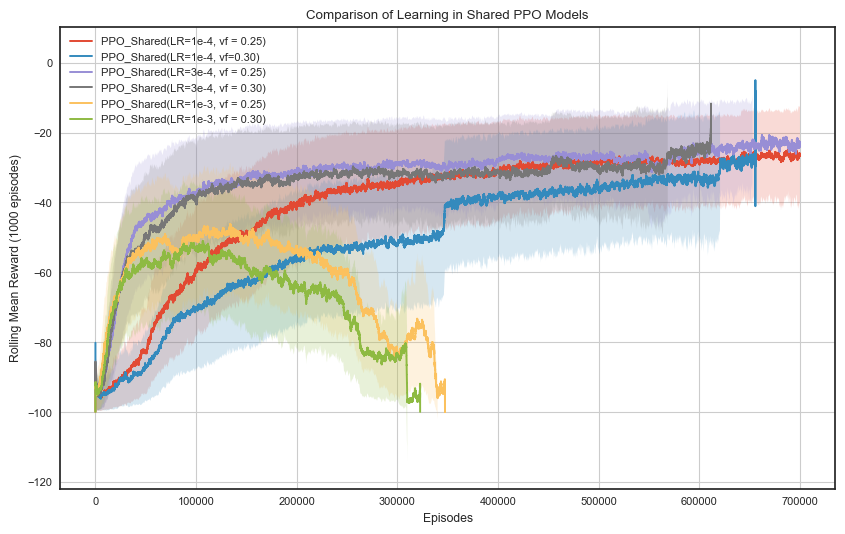

In [ ]:
#Plotting Comparison
dataframe = pd.read_csv('episode_reward_values_shared.csv', header=[0, 1])
models_list = ["PPO_Shared(LR=1e-4, vf = 0.25)", "PPO_Shared(LR=1e-4, vf=0.30)", "PPO_Shared(LR=3e-4, vf = 0.25)", "PPO_Shared(LR=3e-4, vf = 0.30)", "PPO_Shared(LR=1e-3, vf = 0.25)", "PPO_Shared(LR=1e-3, vf = 0.30)",]
plot_title = "Comparison of Learning in Shared PPO Models"

plot_all_models(dataframe, models_list, plot_title, max_episodes = 700000)

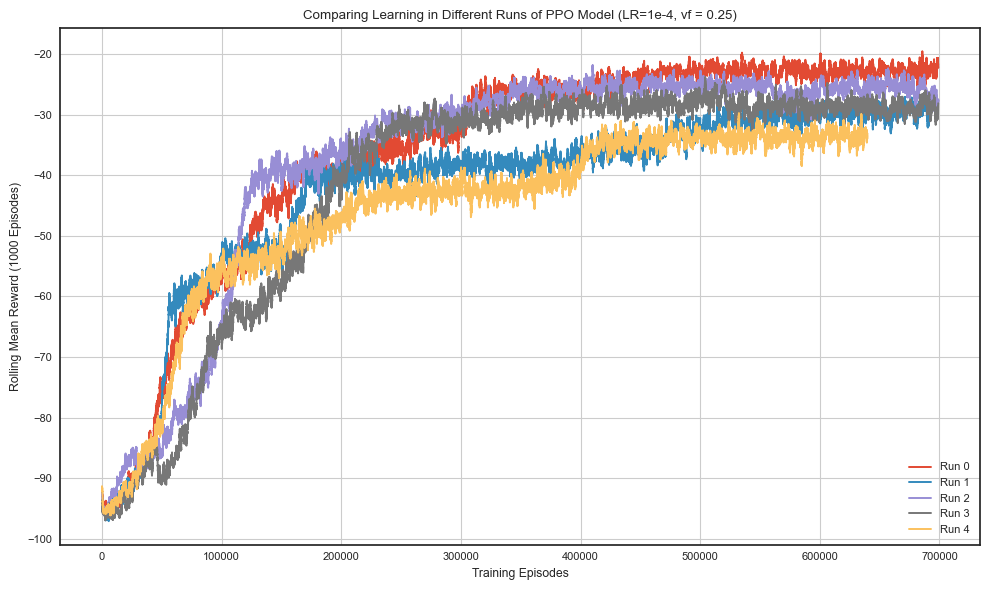

In [29]:
#looking at individual runs
dataframe = pd.read_csv('episode_reward_values_shared.csv', header=[0, 1])
model_name = "PPO_Shared(LR=1e-4, vf = 0.25)"

compare_shared_runs(dataframe, model_name, max_episodes = 700000, window_size = 1000)

TRAINING

In [ ]:
#Training new network
env = GridWorldEnv()
model = PPO(
    CustomActorCriticPolicy,
    env,
    learning_rate=1e-4, #lower learning rate
    gamma=0.99,
    n_steps=2048,
    ent_coef=0.001, #little bit of entropy
    vf_coef=0.25, #reduce vf learning
    verbose=0,
)

callback = CustomCallback(env, model_name="Shared_PPO")
model.learn(total_timesteps=35000000, progress_bar=True, callback=callback)

model.save(f"Shared_PPO.zip")
np.save("episode_rewards_shared_PPO.npy", np.array(callback.episode_rewards))

In [ ]:
## Plotting seperate and shared PPO learning
episode_rewards_stablebaselines = np.load("episode_rewards_seperate_PPO.npy").tolist()
episode_rewards_shared = np.load("episode_rewards_shared_PPO.npy").tolist()

# Rolling mean function
def rolling_mean(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 1000

plt.figure(figsize=(10, 6))
#Plot Stablebaseline reward
if len(episode_rewards_stablebaselines) >= window_size:
    smoothed_stable = rolling_mean(episode_rewards_stablebaselines, window_size)
    plt.plot(smoothed_stable, label="Separate-Parameters PPO")

#Plot two shared layers reward
if len(episode_rewards_shared) >= window_size:
    smoothed_two_shared = rolling_mean(episode_rewards_shared, window_size)
    plt.plot(smoothed_two_shared, label="Shared-Parameters PPO")

# Labels and title
plt.xlabel("Training Episodes")
plt.ylabel("Rolling Mean Reward (1000 Episodes)")
plt.title("Comparing Learning in Separate- and Shared-Paramater PPO Agents")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=8)
plt.grid()
plt.tight_layout()
plt.show()

ANALYSIS

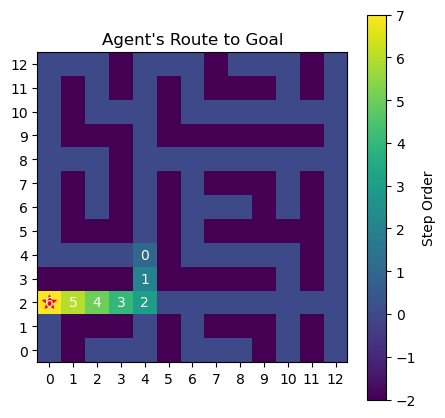

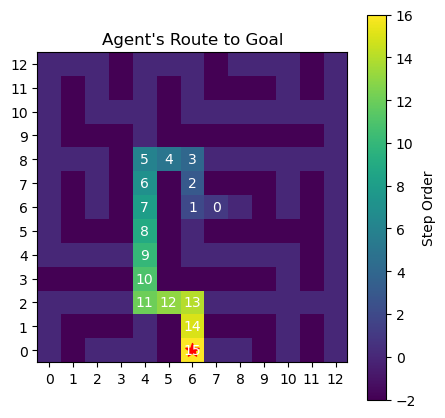

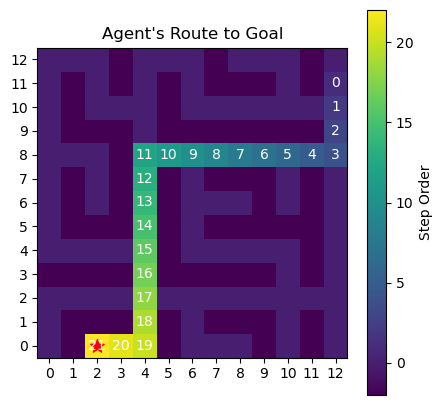

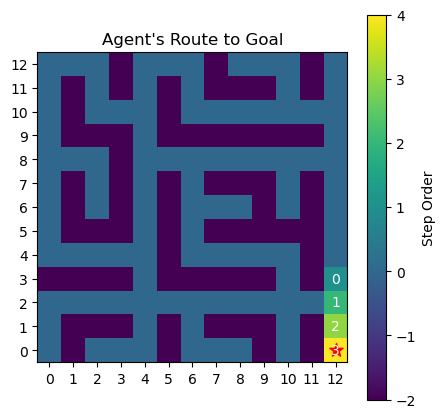

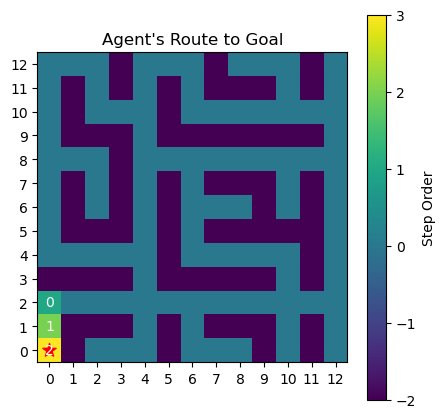

In [3]:
#Extract representations
env = GridWorldEnv()
model = PPO.load("PPO_Shared.zip")

#visualise trained route
for i in range(5):
    visualize_trained_route(env,model)

In [ ]:
#store representations
env = GridWorldEnv()
model = PPO.load("PPO_Shared.zip")

store_shared_PPO_all_activations(env, model)
store_shared_PPO_timestep_activations(env, model, num_repeats=50)

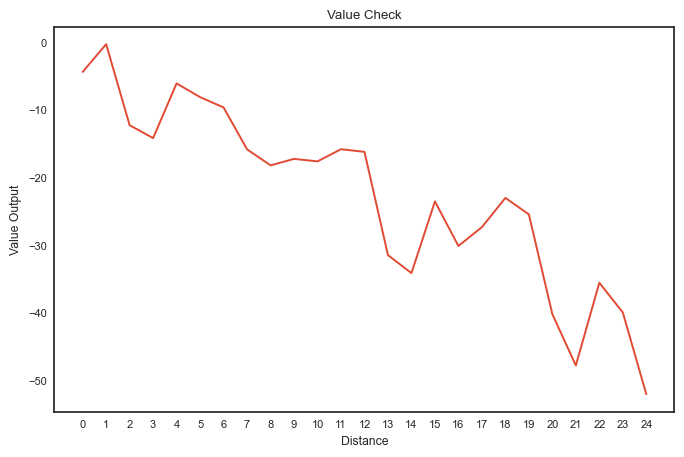

Mean Squared Error: 10.0658
R² Score: 0.6068


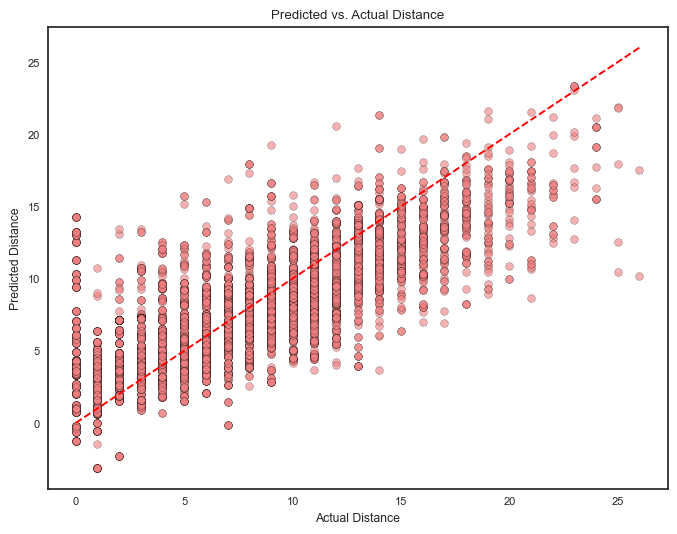

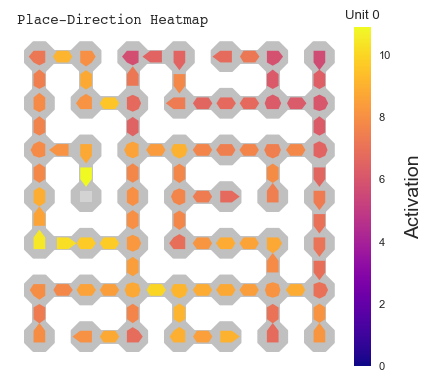

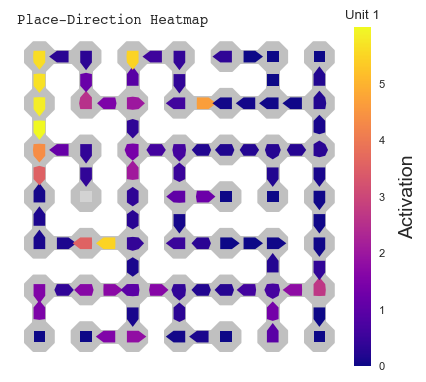

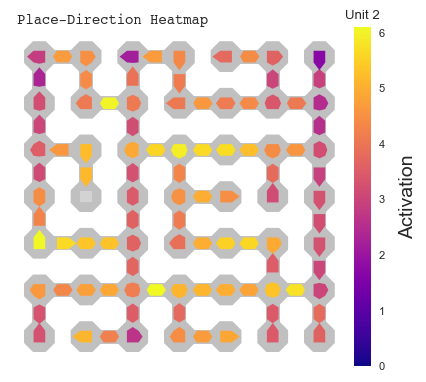

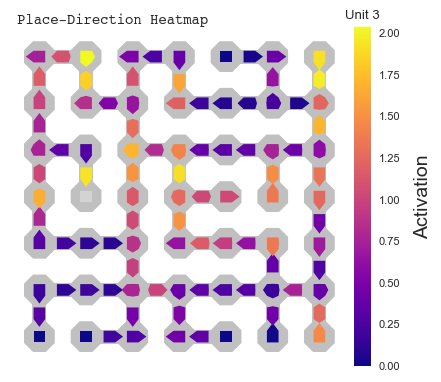

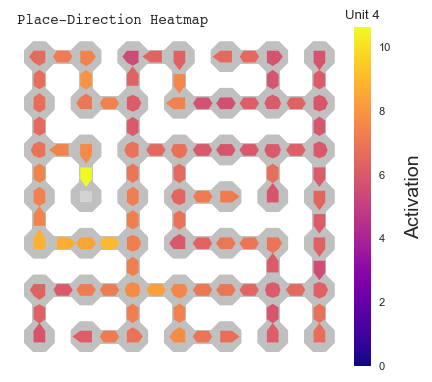

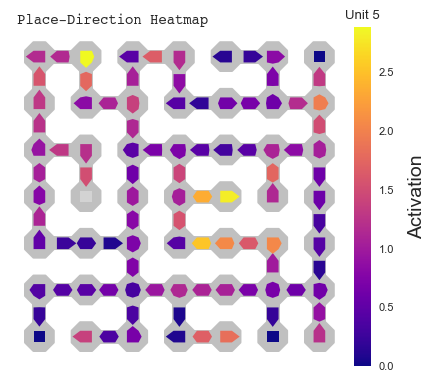

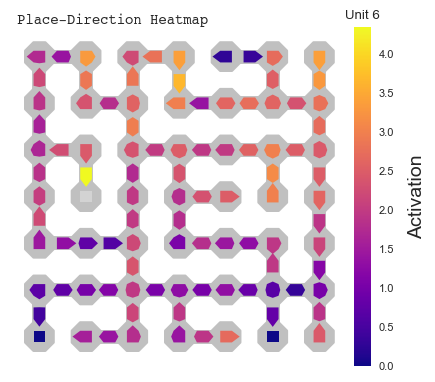

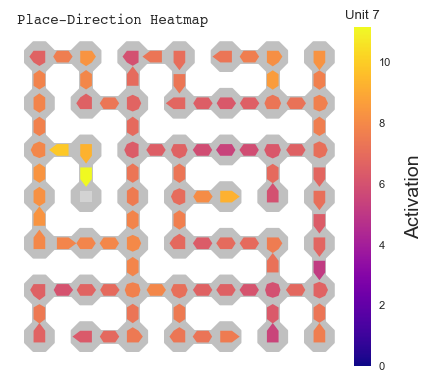

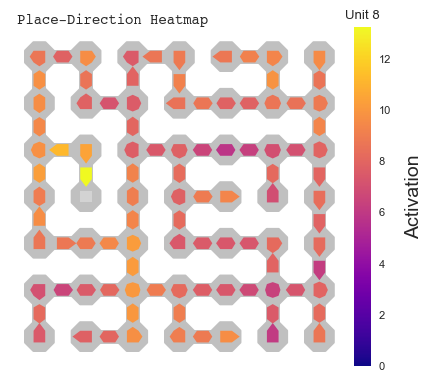

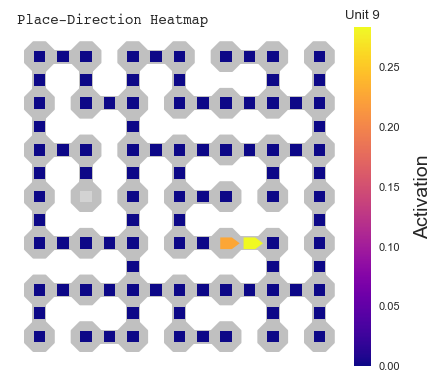

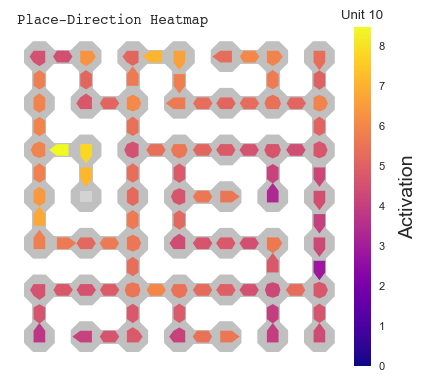

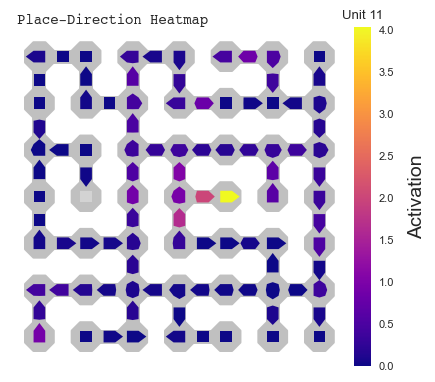

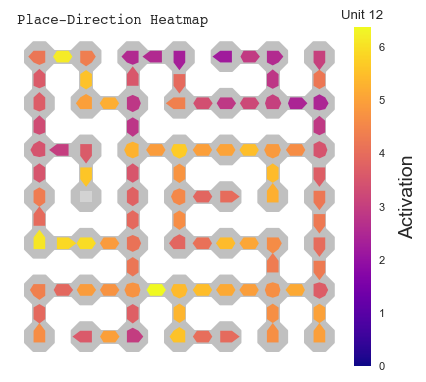

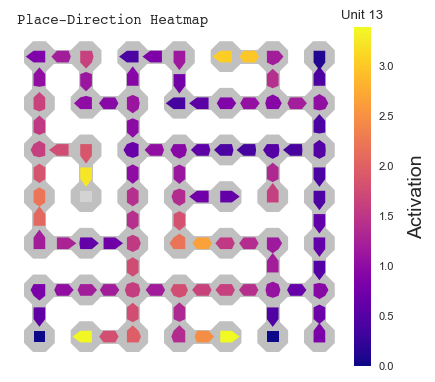

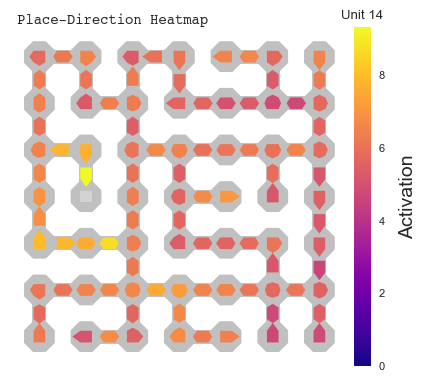

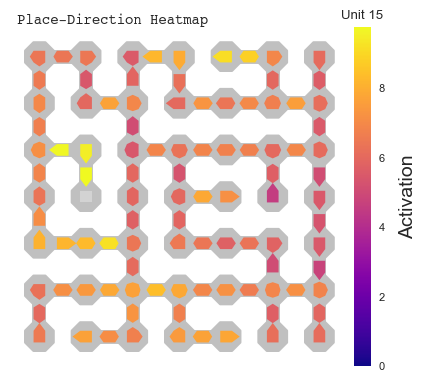

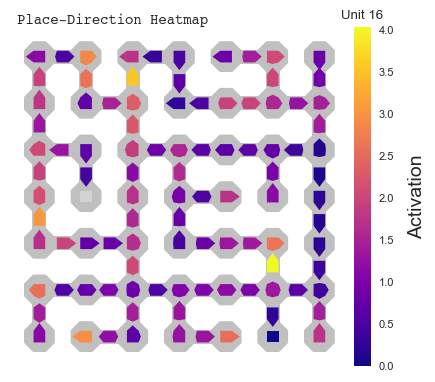

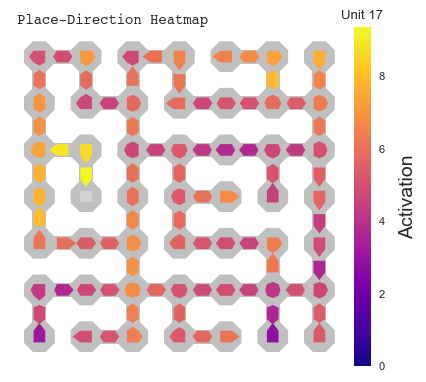

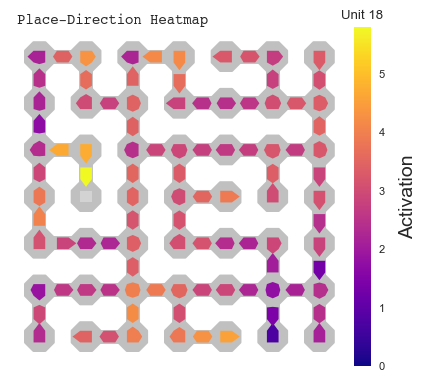

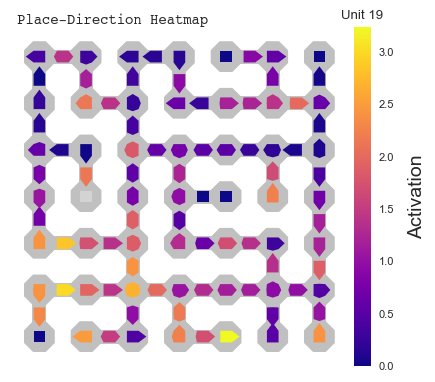

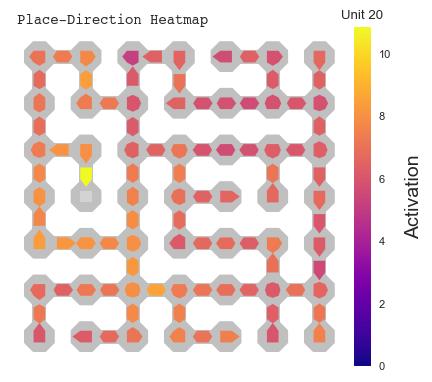

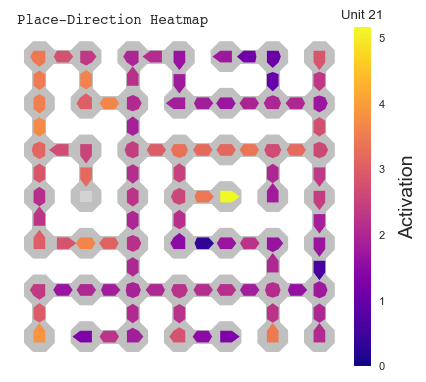

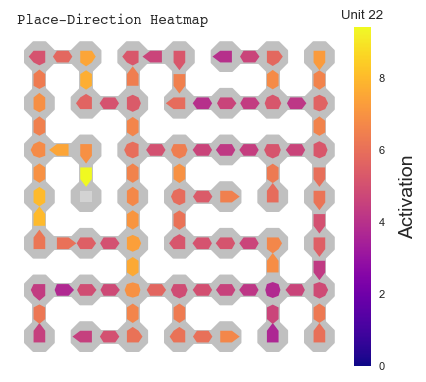

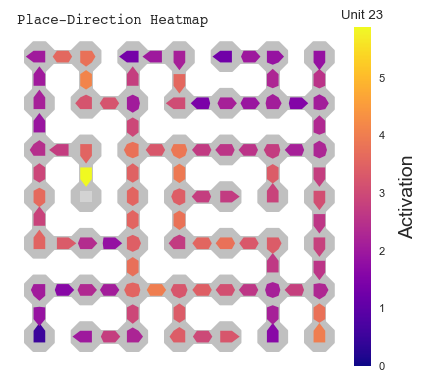

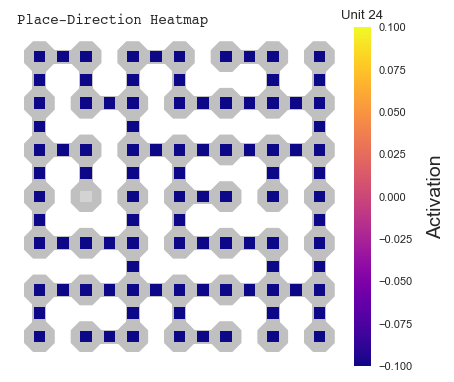

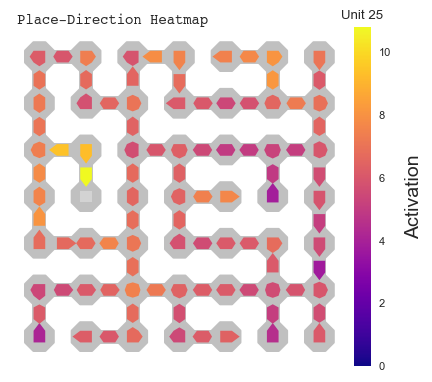

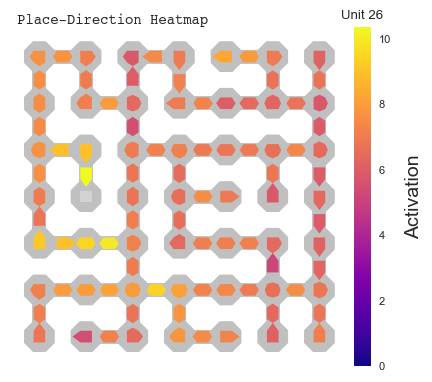

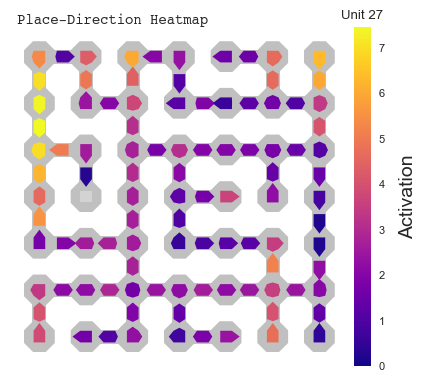

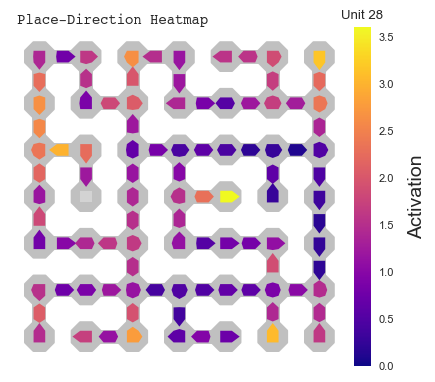

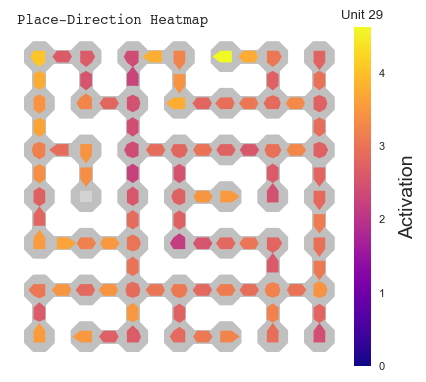

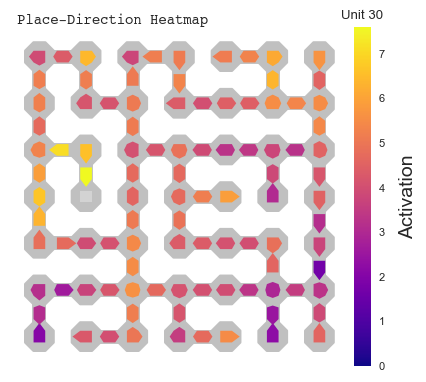

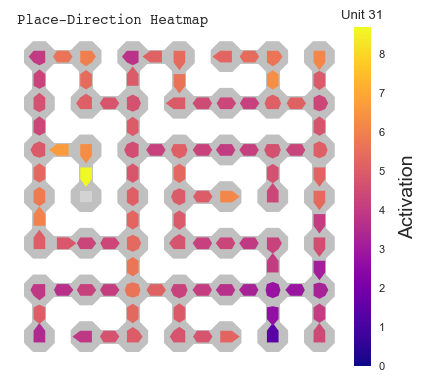

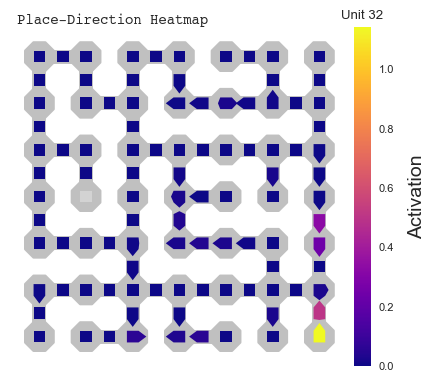

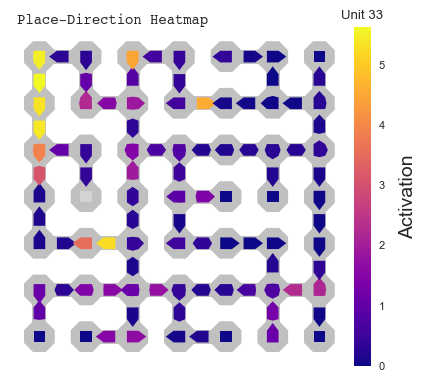

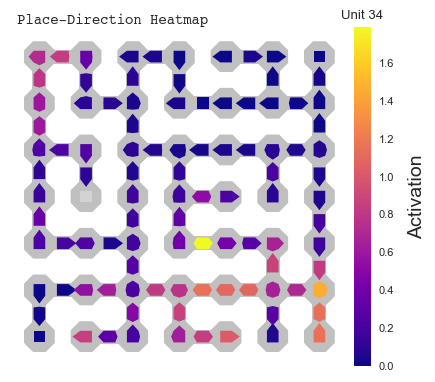

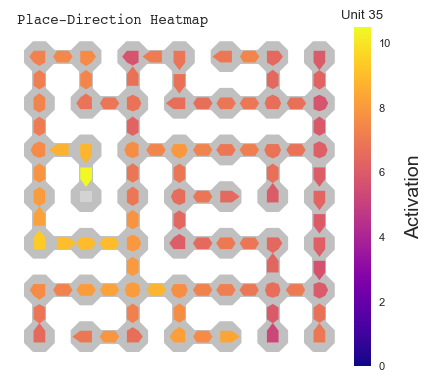

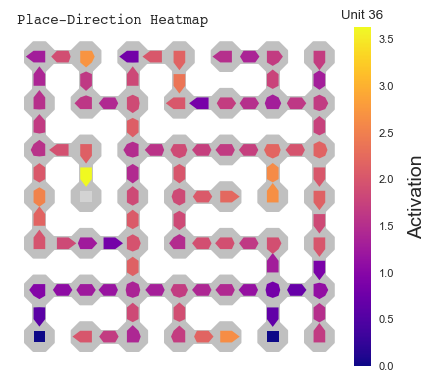

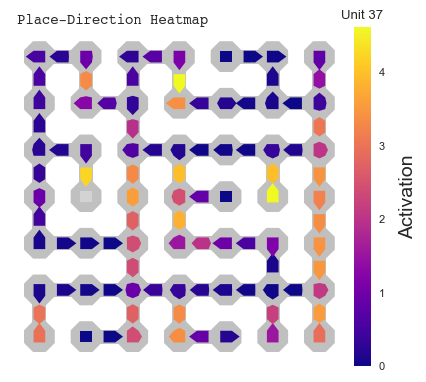

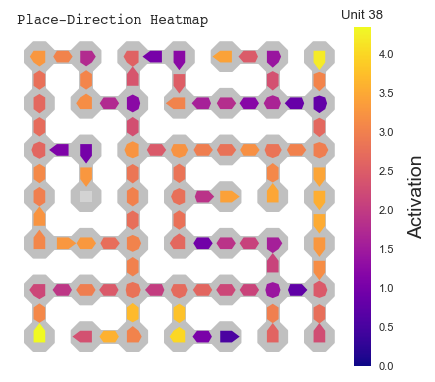

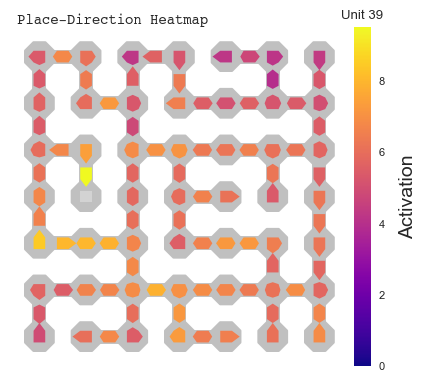

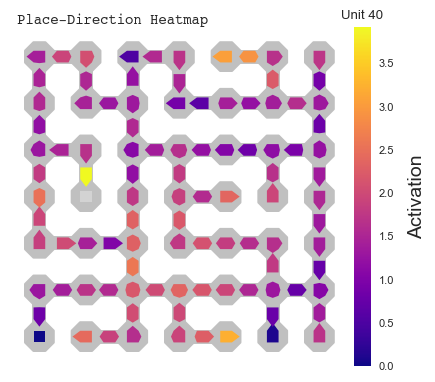

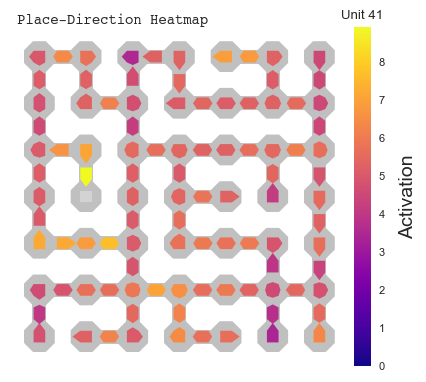

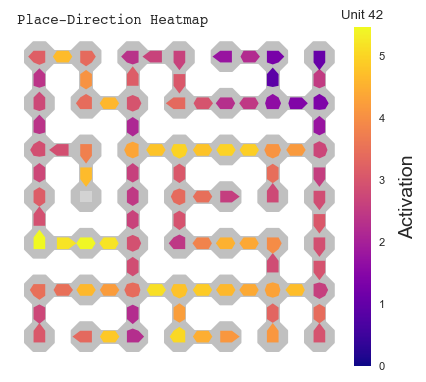

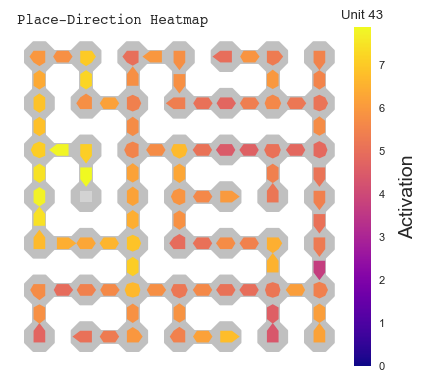

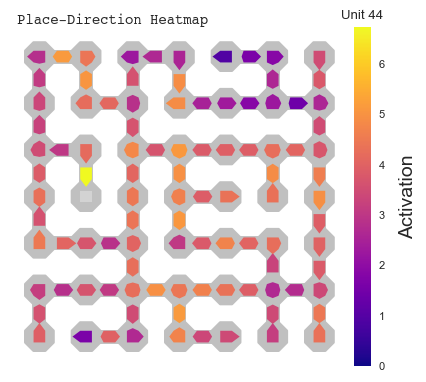

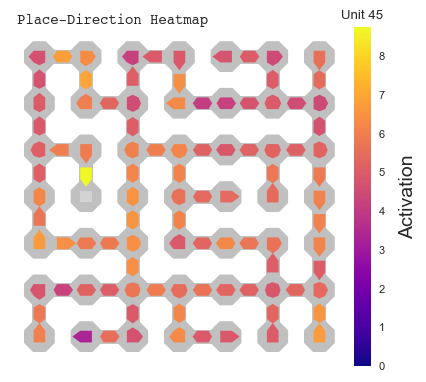

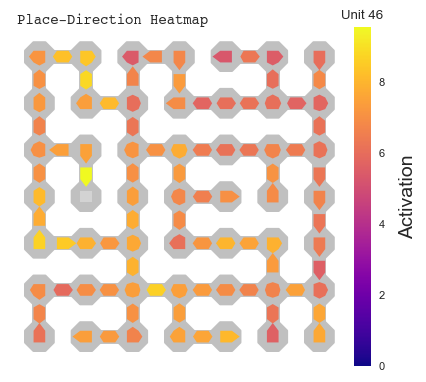

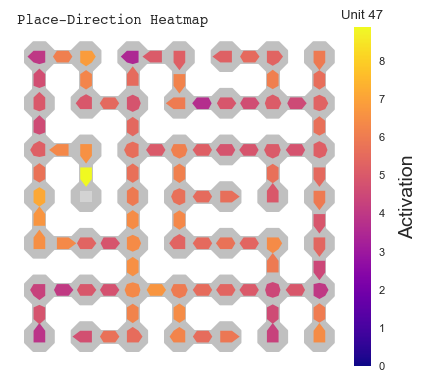

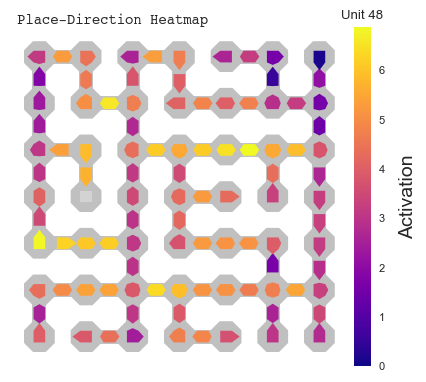

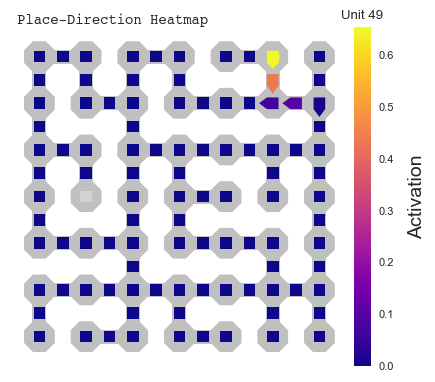

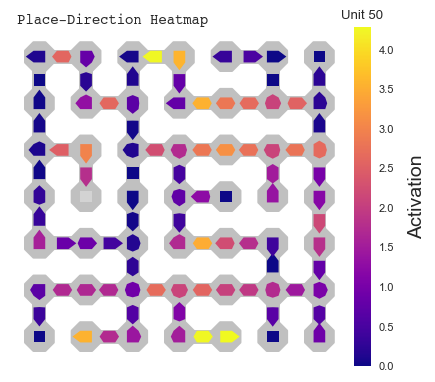

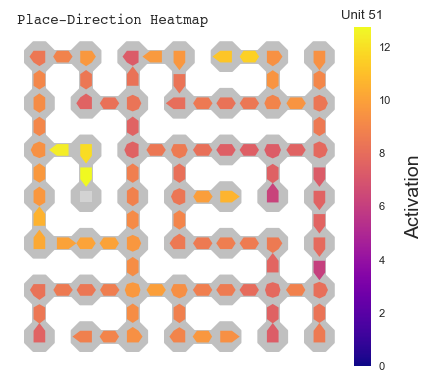

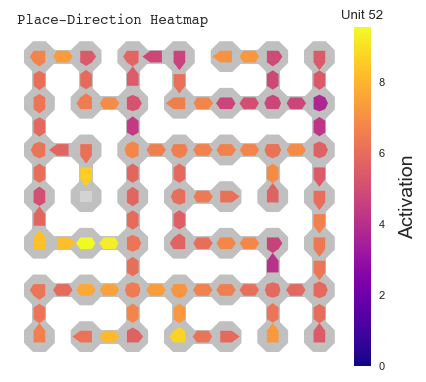

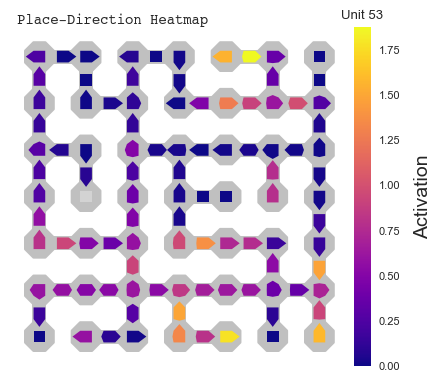

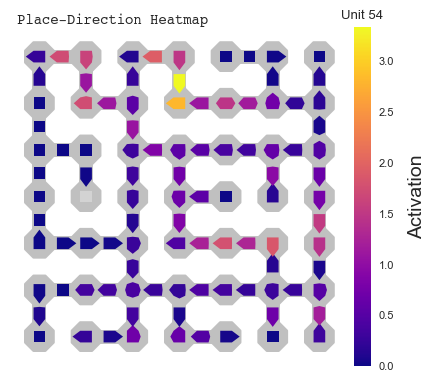

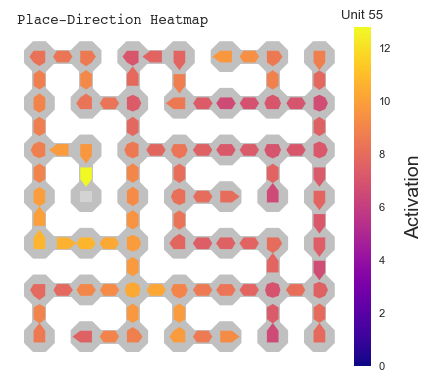

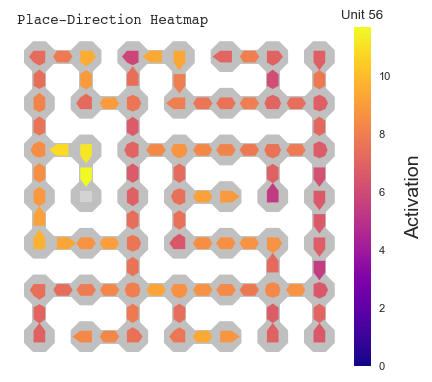

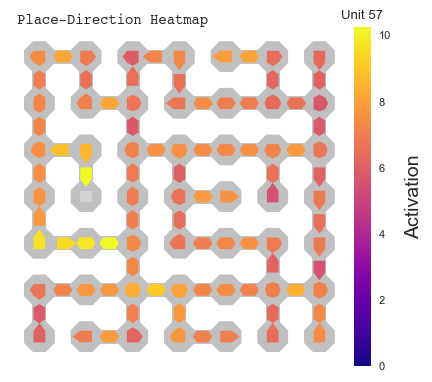

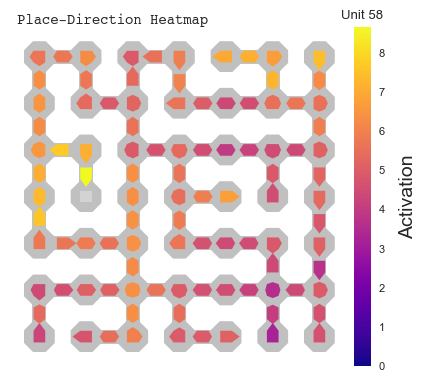

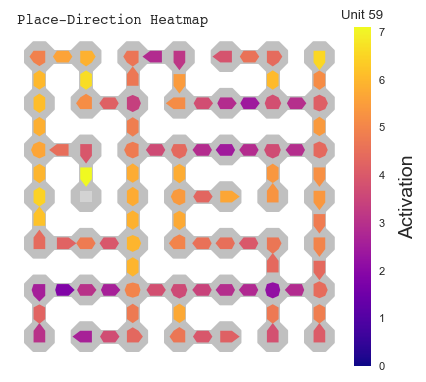

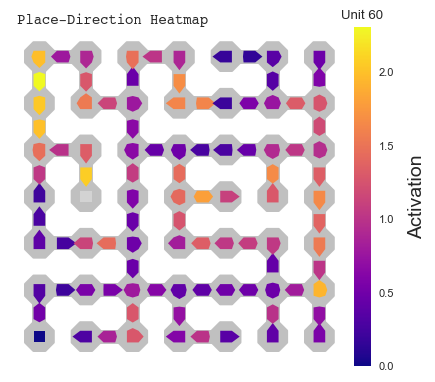

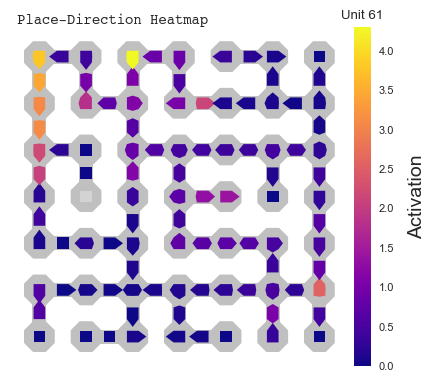

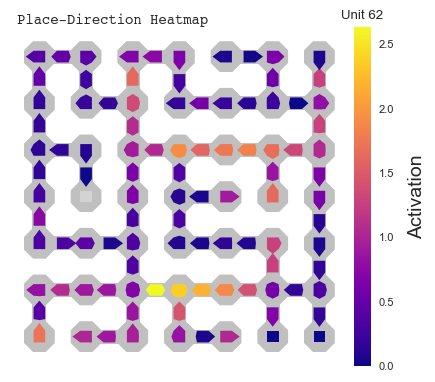

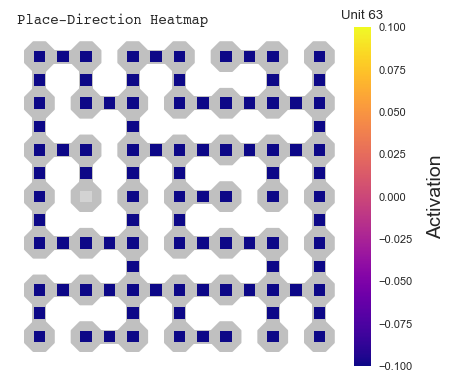

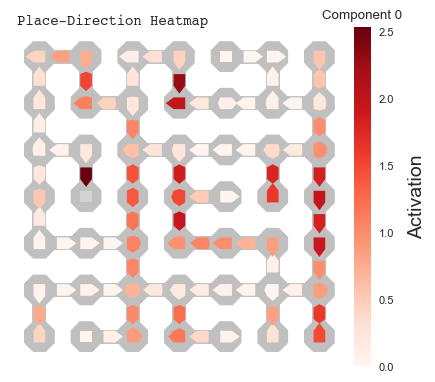

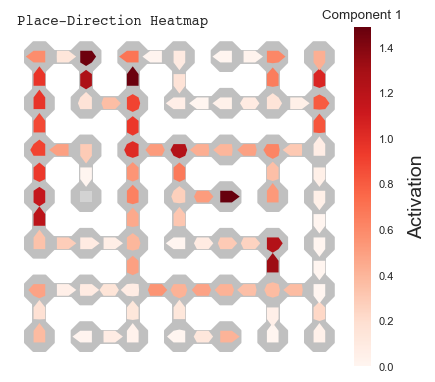

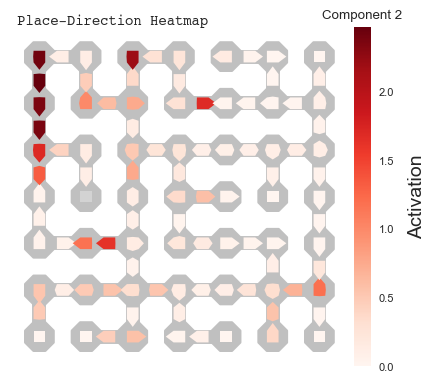

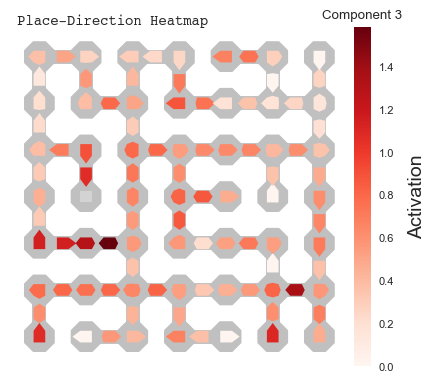

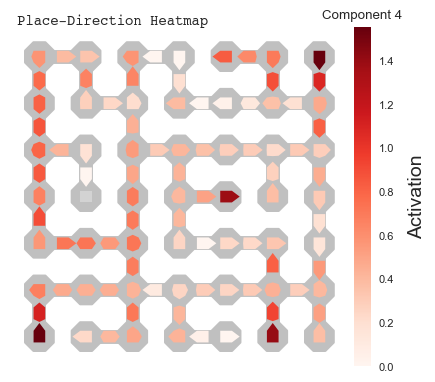

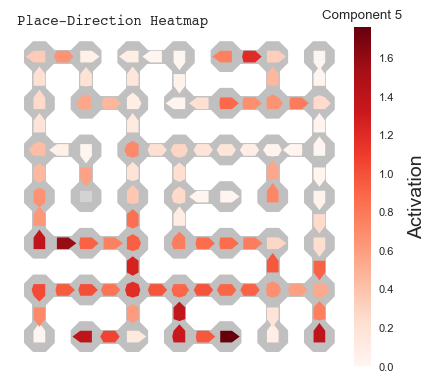

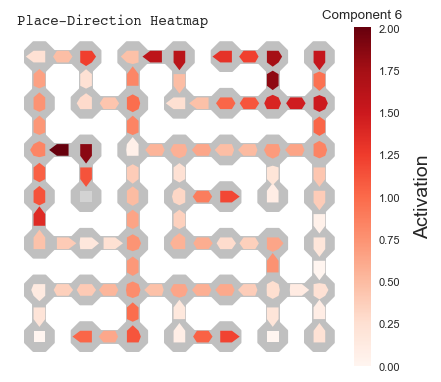

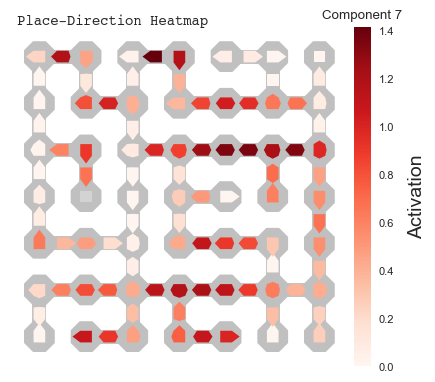

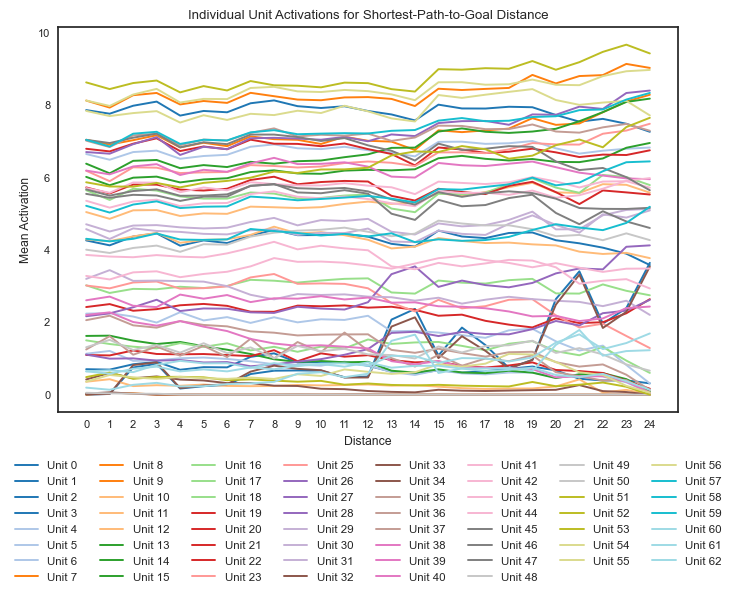

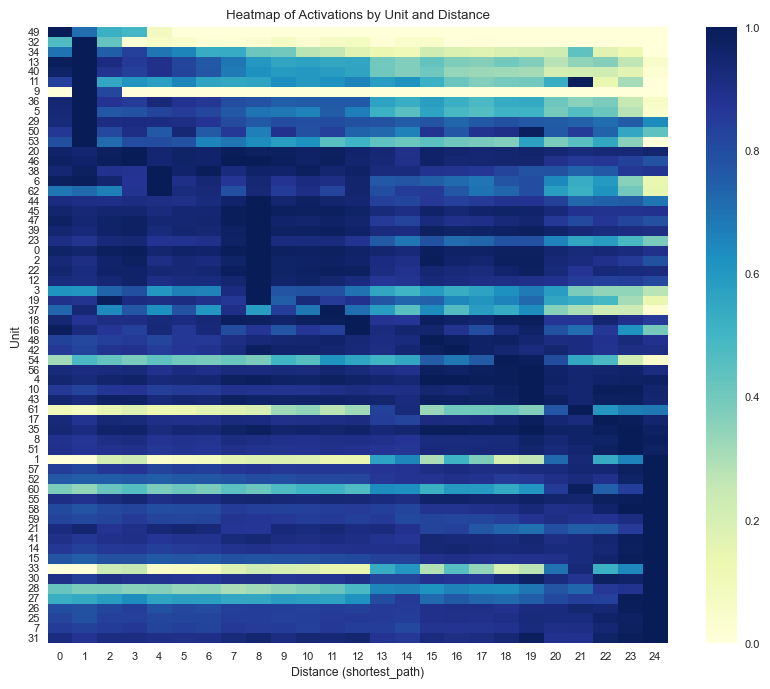

In [25]:
#Plotting 
env = GridWorldEnv()
dataframe = pd.read_csv('store_shared_PPO_timestep_activations.csv', header=[0, 1])
interested_units = range(64)
distance1 = "euclidean_distance"
distance2 = "shortest_path"

all_plots(env, dataframe, distance2, interested_units, num_components=8)

Vector Distance vs Spatial Distance Analysis

Running permutations: 100%|██████████| 5000/5000 [03:24<00:00, 24.48it/s]


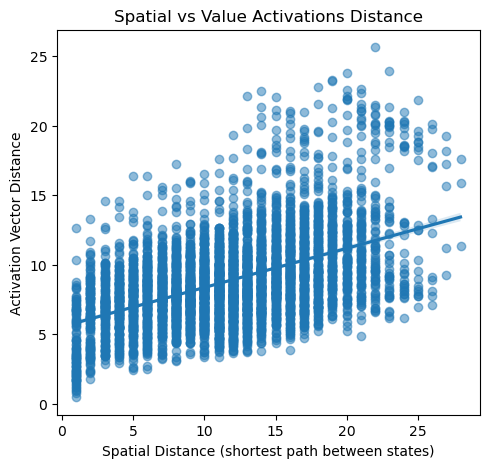

Spearman’s ρ: 0.4496, perm. p = 0.0000


In [4]:
#For all goals
env = GridWorldEnv()
dataframe = pd.read_csv('store_shared_PPO_all_activations.csv', header=[0, 1])
distance_metric = "shortest_path"
activations_name = "activations"

analyze_distance_correlation(env, dataframe, activations_name, distance_metric)

In [ ]:
#For individual goals 
env = GridWorldEnv()
dataframe = pd.read_csv('store_shared_PPO_all_activations.csv', header=[0, 1])
distance_metric = "shortest_path"
sorted_tower_spaces = sorted(env.towers_index)
activations_name = "activations"

for goal in sorted_tower_spaces:
    interested_goal_string = env.string_dictionary.get(goal, str(goal))
    analyze_specific_distance_correlation(env, dataframe, interested_goal_string, activations_name, distance_metric)